## Introduction

#### 48E.01 Assignment 1 - 2024

#### Contributors:
- **Umut Bülbül**
- **Çağan Gürdal**

## Part A: Data Analysis of Financial Time Series Using Python

### Initialization

In [95]:
from typing import Dict, List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import skew, t
import statsmodels.formula.api as smf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

import matplotlib.ticker as ticker

# List of tickers for the different series
tickers = ["GOOGL", "AAPL", "AMZN", "NVDA", "BTC-USD", "^IXIC", "^SPX", "AKBNK.IS", "TUPRS.IS", "XU100.IS"]

---
Here, we create the necessary functions "log_returns" and "weighted_variance".

In [96]:
def log_returns(series: pd.Series):
    return np.log(series / series.shift(1))

In [97]:
def weighted_variance(variables: List[np.array], weights: np.array):
    data_matrix = np.column_stack(variables)
    cov_matrix = np.cov(data_matrix, rowvar=False, ddof=1)

    return np.dot(weights.T, np.dot(cov_matrix, weights))

---
We download the stock prices from Yahoo Finance.

In [98]:
tickers_yf = yf.download(tickers, start="2021-01-04", interval="1d").loc[
    :, pd.IndexSlice["Close"]
]

[*********************100%***********************]  10 of 10 completed


### 1) Prices and Returns
We categorize the prices with respect to their periods, calculate their returns and their cumulative returns.

In [99]:
prices: Dict[str, pd.DataFrame] = {
    "Daily": tickers_yf,
    "Weekly": tickers_yf.resample("W").last(),
    "Monthly": tickers_yf.resample("ME").last(),
    "Yearly": tickers_yf.resample("YE").last(),
}

prices["Yearly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Date,,,,,,,,,,
2021-12-31 00:00:00+00:00,177.570007,7.200000,166.716995,46306.445312,144.852005,29.410999,22.057142,1857.699951,15644.969727,4766.180176
2022-12-31 00:00:00+00:00,129.929993,19.549999,84.000000,16547.496094,88.230003,14.614000,75.699997,5509.200195,10466.480469,3839.500000
2023-12-31 00:00:00+00:00,192.529999,36.520000,151.940002,42265.187500,139.690002,49.521999,143.000000,7470.200195,15011.349609,4769.830078
2024-12-31 00:00:00+00:00,230.570007,49.880001,186.380005,67904.468750,162.720001,140.410004,145.500000,8843.730469,18415.490234,5809.859863


In [100]:
returns: Dict[str, pd.DataFrame] = {
    period: prices_df.pct_change(fill_method=None).dropna()
    for period, prices_df in prices.items()
}
returns["Yearly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Date,,,,,,,,,,
2022-12-31 00:00:00+00:00,-0.268289,1.715278,-0.496152,-0.642652,-0.390896,-0.503111,2.431995,1.965603,-0.331000,-0.194428
2023-12-31 00:00:00+00:00,0.481798,0.868031,0.808810,1.554174,0.583248,2.388668,0.889036,0.355950,0.434231,0.242305
2024-12-31 00:00:00+00:00,0.197580,0.365827,0.226668,0.606629,0.164865,1.835306,0.017483,0.183868,0.226771,0.218043


In [101]:
returns_cumulative: Dict[str, pd.DataFrame] = {
    period: (1 + returns_df).cumprod()
    for period, returns_df in returns.items()
}
returns_cumulative["Yearly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Date,,,,,,,,,,
2022-12-31 00:00:00+00:00,0.731711,2.715278,0.503848,0.357348,0.609104,0.496889,3.431995,2.965603,0.669000,0.805572
2023-12-31 00:00:00+00:00,1.084248,5.072222,0.911365,0.912728,0.964364,1.683792,6.483161,4.021209,0.959500,1.000766
2024-12-31 00:00:00+00:00,1.298474,6.927778,1.117942,1.466415,1.123353,4.774064,6.596503,4.760581,1.177087,1.218976


### 2) Price and Return Statistics

We calculate the statistics of the prices for all periods.

In [102]:
prices_stats: Dict[str, pd.DataFrame] = {
    period: pd.DataFrame(
        {
            "Mean": prices_df.mean(),
            "STD": prices_df.std(),
            "Skew": prices_df.apply(skew),
            "Kurtosis": prices_df.kurtosis(),
        },
        columns=pd.Index(["Mean", "STD", "Skew", "Kurtosis"], name="Statistics"),
    ).T
    for period, prices_df in prices.items()
}
prices_stats["Monthly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Statistics,,,,,,,,,,
Mean,166.912391,22.653261,146.690891,40810.805112,128.266837,42.704522,79.782143,4968.452870,14037.564326,4475.256491
STD,29.039527,19.610202,29.815167,16117.900420,24.272391,36.374249,61.146734,3259.865061,2090.507537,564.989569
Skew,0.552698,1.000585,-0.387863,0.283078,0.259665,1.386520,0.444455,0.394314,0.306193,0.830257
Kurtosis,-0.129036,-0.248410,-1.005768,-1.139041,-0.649967,0.823635,-1.392091,-1.366931,-0.545833,0.041073


---
We calculate the statistics of the returns for all periods.

In [103]:
returns_stats: Dict[str, pd.DataFrame] = {
    period: pd.DataFrame(
        {
            "Mean": returns_df.mean(),
            "STD": returns_df.std(),
            "Skew": returns_df.apply(skew),
            "Kurtosis": returns_df.kurtosis(),
        },
        columns=pd.Index(["Mean", "STD", "Skew", "Kurtosis"], name="Statistics"),
    ).T
    for period, returns_df in returns.items()
}
returns_stats["Monthly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Statistics,,,,,,,,,,
Mean,0.015174,0.055220,0.007627,0.032647,0.015808,0.066375,0.060610,0.044750,0.009302,0.011070
STD,0.074793,0.135993,0.094101,0.185959,0.076895,0.158334,0.129301,0.095178,0.057917,0.046814
Skew,0.080755,0.374624,0.318728,0.240533,-0.259979,-0.249169,0.467962,0.596575,-0.381076,-0.503064
Kurtosis,-0.722489,0.138038,1.127699,0.053197,-0.307990,-0.476074,0.003995,-0.155923,-0.100194,-0.355106


### 3) Tables and Plotting

#### Comparative Tables and Analysis:

In [104]:
compact_index = pd.Index(
    [f"{i} (Daily)" for i in returns_stats["Daily"].index]
    + [f"{i} (Weekly)" for i in returns_stats["Weekly"].index]
    + [f"{i} (Monthly)" for i in returns_stats["Monthly"].index],
    name="Statistics",
)
compact_table = pd.concat(
    [
        returns_stats["Daily"],
        returns_stats["Weekly"],
        returns_stats["Monthly"],
    ],
    ignore_index=True,
).round(4)
compact_table.index = compact_index
compact_table

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Statistics,,,,,,,,,,
Mean (Daily),0.0008,0.0009,0.0005,0.0014,0.0010,0.0030,0.0018,0.0013,0.0005,0.0006
STD (Daily),0.0170,0.0292,0.0236,0.0342,0.0199,0.0345,0.0255,0.0175,0.0145,0.0107
Skew (Daily),0.2624,-0.0170,0.1031,-0.0388,0.0867,0.8720,-0.0275,-0.7420,-0.0043,-0.0863
Kurtosis (Daily),2.5820,1.8717,5.2371,1.9579,3.6991,4.5273,2.2465,4.2260,1.1933,1.6801
Mean (Weekly),0.0035,0.0125,0.0018,0.0064,0.0039,0.0143,0.0132,0.0097,0.0021,0.0024
STD (Weekly),0.0361,0.0767,0.0456,0.0834,0.0432,0.0691,0.0638,0.0402,0.0291,0.0223
Skew (Weekly),0.1261,0.1960,-0.0827,0.0263,0.3541,0.2333,0.6504,0.0703,0.0568,0.0169
Kurtosis (Weekly),0.4034,1.4349,0.9144,1.1574,0.5522,0.3461,2.1032,0.3961,-0.0693,0.5754
Mean (Monthly),0.0152,0.0552,0.0076,0.0326,0.0158,0.0664,0.0606,0.0447,0.0093,0.0111



**Key Findings:**
1. **Mean Returns**:
    - **Daily**: Daily mean returns are generally small across assets, with NVDA and TUPRS.IS showing slightly higher values.
    - **Weekly**: Weekly returns are more pronounced, with Turkish assets (AKBNK.IS, TUPRS.IS) and NVDA showing particularly high averages.
    - **Monthly**: Monthly returns follow the weekly trend, with NVDA and TUPRS.IS leading.

2. **Standard Deviation (Risk)**:
    - **Daily**: BTC-USD and NVDA exhibit the highest volatility, highlighting their risk. U.S. indices (^SPX, ^IXIC) show the lowest.
    - **Weekly**: Weekly volatility aligns with daily patterns, with BTC-USD and NVDA again the highest.
    - **Monthly**: Volatility increases over monthly intervals, with BTC-USD most volatile.

3. **Skewness**:
    - **Daily**: Most assets show near-zero skew, indicating relatively symmetrical returns, though NVDA is notably right-skewed.
    - **Weekly**: More mixed skew, with TUPRS.IS displaying notable positive skew, hinting at a higher frequency of positive weekly returns.
    - **Monthly**: Monthly skew is more variable, with assets like GOOGL and ^SPX showing negative skew.

4. **Kurtosis**:
    - **Daily**: NVDA, AMZN, and TUPRS.IS display higher kurtosis, suggesting frequent extreme values (heavy tails).
    - **Weekly**: Most weekly returns are within moderate kurtosis, though TUPRS.IS has heavier tails.
    - **Monthly**: Monthly returns exhibit mostly normal-like tails, with minor deviations from zero, suggesting fewer outliers.

**Conclusion:**
It is revealed that BTC-USD and NVDA are the most volatile instruments across all frequencies, offering higher returns but at the cost of increased risk. The skewness and kurtosis values suggest that return distributions are not perfectly normal, with some stocks exhibiting significant deviations from normality.

#### Configure the constants for the graphs:

In [105]:
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY75 = "#bfbfbf"
GREY85 = "#d9d9d9"

COLOR_SCALE = [
    "#6D3E91",
    "#C05917",
    "#58AC8C",
    "#286BBB",
    "#883039",
    "#BC8E5A",
    "#00295B",
    "#C15065",
]

US_TEXTS = [
    "US Stock Returns",
    "How the US stock returns have performed over the last years compared to the S&P 500 Index",
    "Source: Yahoo Finance",
]

TR_TEXTS = [
    "TR Stock Returns",
    "How the TR stock returns have performed over the last years compared to the BIST 100 Index",
    "Source: Yahoo Finance",
]

#### Define the necessary functions:

In [106]:
def config_ax(ax, x_label, y_label):
    ax.yaxis.set_major_locator(ticker.MaxNLocator(6))

    [ax.spines[k].set_color("none") for k in ax.spines.keys() if k != "bottom"]
    ax.spines["bottom"].set_color(GREY40)

    ax.tick_params(axis="x", rotation=45, colors=GREY40)
    ax.tick_params(axis="y", width=0)

    ax.set_xlabel(
        x_label, fontsize=12, fontweight="bold", fontname="Arial", color=GREY10
    )
    ax.set_ylabel(
        y_label,
        fontsize=12,
        fontweight="bold",
        fontname="Arial",
        color=GREY10,
    )


def config_fig(fig, texts):
    fig.text(
        0.015,
        0.95,
        texts[0],
        fontsize=20,
        color=GREY40,
        fontname="Georgia",
        weight="bold",
    )
    fig.text(0.015, 0.93, texts[1], fontsize=12, color=GREY30, fontname="Arial")
    fig.text(0.015, 0.02, texts[2], fontsize=10, color=GREY30, fontname="Arial")
    fig.subplots_adjust(left=0.09, right=0.70, top=0.9, bottom=0.1, hspace=0.4)


def plot_data(ax, x, y, offset_proportions):
    x_range = (x.values[-1] - x.values[0]).astype("timedelta64[D]").astype(int)
    x_offset_int = int(x_range * 0.02)
    x_offset = np.timedelta64(x_offset_int, "D")
    x_location = x.values[-1]

    for idx, column in enumerate(y.columns):
        column_data = y[column]

        # Pick a Color from palette
        color = COLOR_SCALE[idx]

        # Plot each line with some round markers
        ax.plot(
            x,
            column_data,
            label=column,
            color=color,
            linestyle="-",
            marker="o",
            markersize=1,
            lw=1.2,
            clip_on=False,
        )

        # Add annotation with name of each series
        y_location = column_data.values[-1]

        ax.text(
            x_location + x_offset,
            y_location + y_location * offset_proportions[idx],
            column,
            color=color,
            fontsize=6,
            va="center",
        )

        # Add arrow between line to annotation
        ax.arrow(
            x_location,
            y_location,
            x_offset_int,
            y_location * offset_proportions[idx],
            clip_on=False,
            color=GREY75,
        )


def config_layout(ax, min_x, max_x):
    ax_ticks = ax.get_yticks()
    ax.set_yticks(ax_ticks)
    ax.set_yticklabels(
        [f"{int(t * 100)}%" for t in ax_ticks],
        fontsize=8,
        weight=500,
        color=GREY40,
    )

    ax.set_xlim(min_x, max_x)
    ax.grid(axis="y", linestyle="--", color=GREY85)


#### The plot for US stock returns (cumulative):

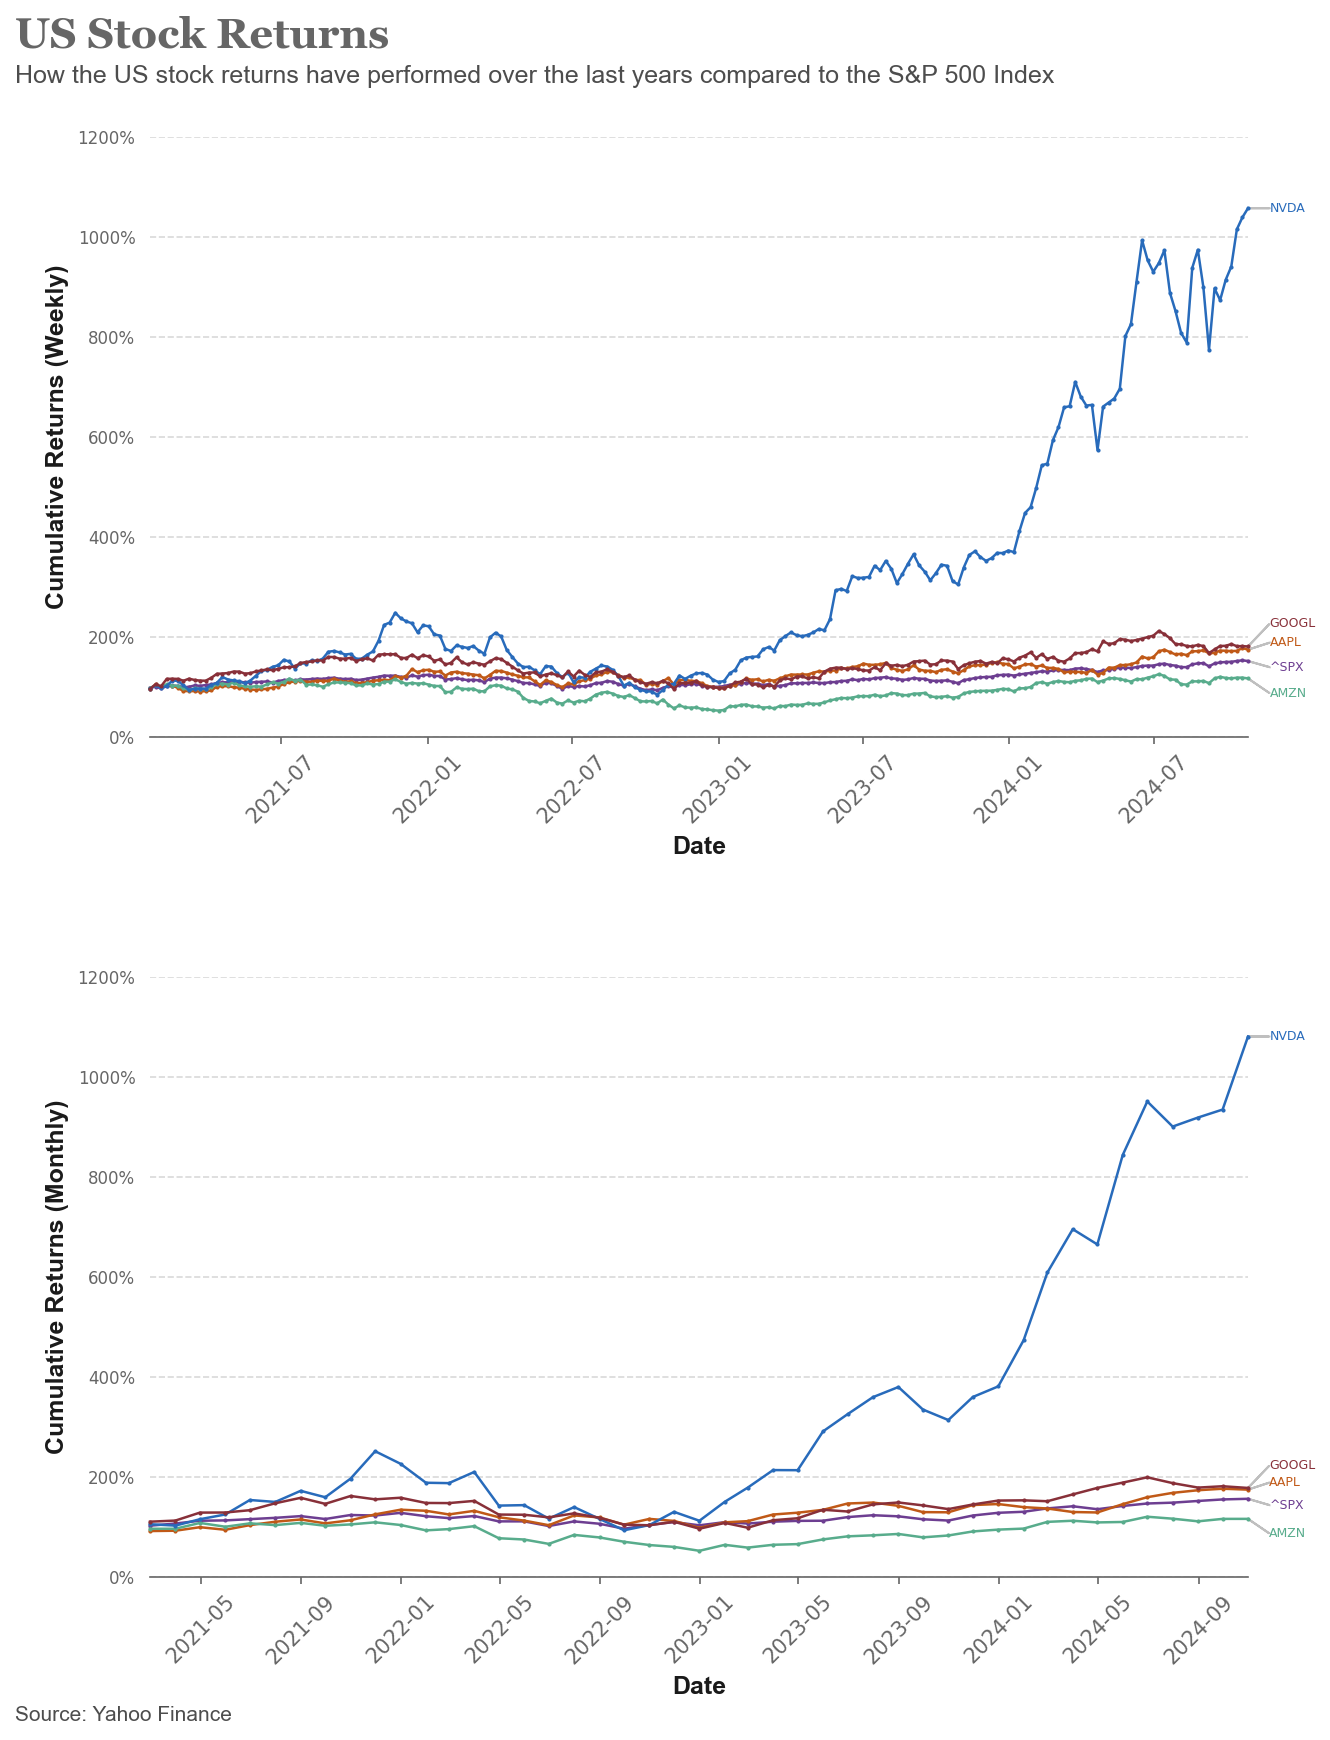

In [107]:
us_fig, (us_ax_1, us_ax_2) = plt.subplots(
    2, 1, figsize=(12, 12), dpi=150, facecolor="white"
)

config_fig(us_fig, US_TEXTS)
config_ax(us_ax_1, "Date", "Cumulative Returns (Weekly)")
config_ax(us_ax_2, "Date", "Cumulative Returns (Monthly)")

# Plot the data
us_x_1 = returns_cumulative["Weekly"].index
us_y_1 = returns_cumulative["Weekly"].loc[:, ["^SPX", "AAPL", "AMZN", "NVDA", "GOOGL"]]
us_y_offset_proportions_1 = [-0.08, 0.08, -0.25, 0.0, 0.25]

plot_data(us_ax_1, us_x_1, us_y_1, us_y_offset_proportions_1)
config_layout(us_ax_1, us_x_1.values[0], us_x_1.values[-1])

us_x_2 = returns_cumulative["Monthly"].index
us_y_2 = returns_cumulative["Monthly"].loc[:, ["^SPX", "AAPL", "AMZN", "NVDA", "GOOGL"]]
us_y_offset_proportions_2 = [-0.08, 0.08, -0.25, 0.0, 0.25]

plot_data(us_ax_2, us_x_2, us_y_2, us_y_offset_proportions_2)
config_layout(us_ax_2, us_x_2.values[0], us_x_2.values[-1])

plt.show()

#### The plot for Turkish stock returns (cumulative):

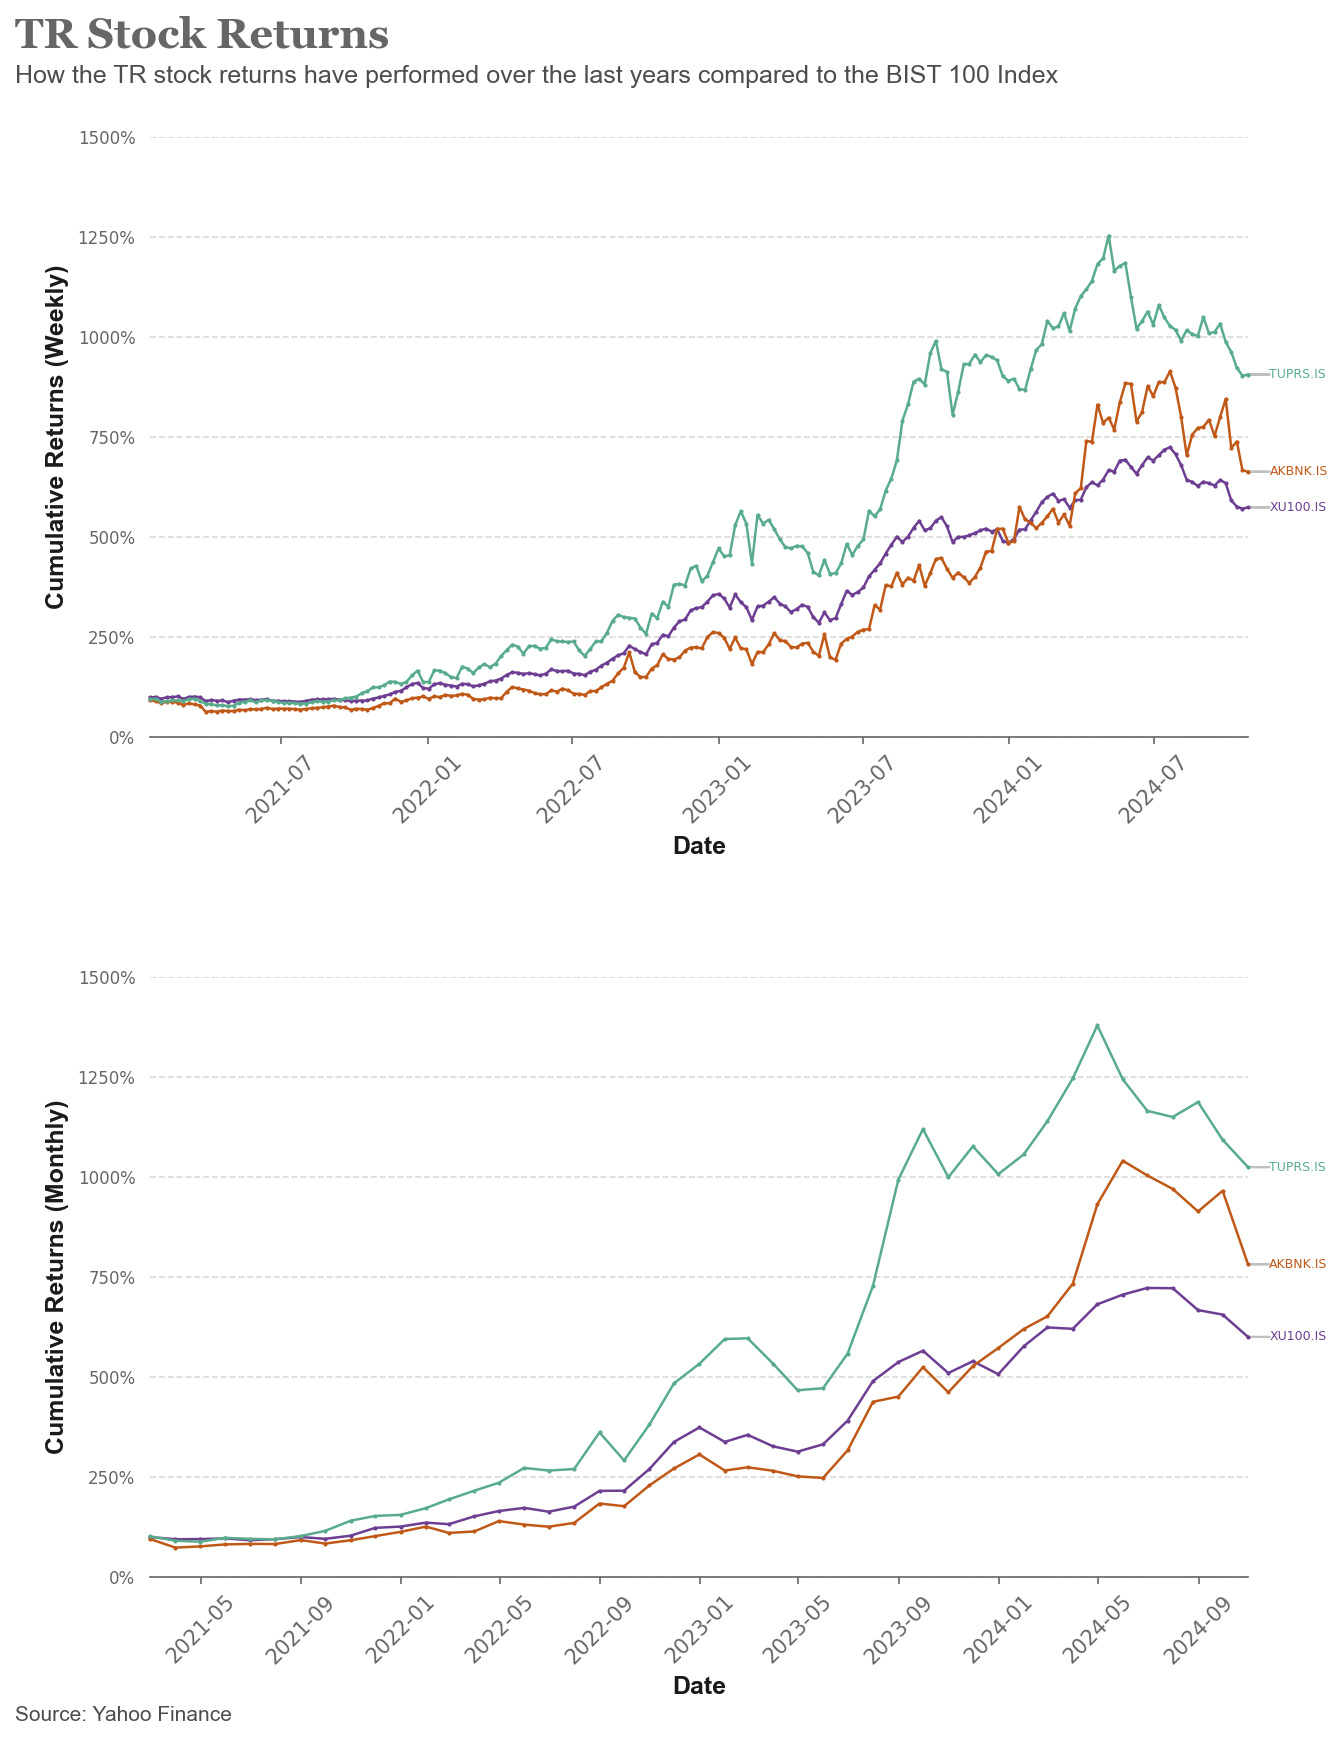

In [108]:
tr_fig, (tr_ax_1, tr_ax_2) = plt.subplots(
    2, 1, figsize=(12, 12), dpi=150, facecolor="white"
)

config_fig(tr_fig, TR_TEXTS)
config_ax(tr_ax_1, "Date", "Cumulative Returns (Weekly)")
config_ax(tr_ax_2, "Date", "Cumulative Returns (Monthly)")

# Plot the data
tr_x_1 = returns_cumulative["Weekly"].index
tr_y_1 = returns_cumulative["Weekly"].loc[:, ["XU100.IS", "AKBNK.IS", "TUPRS.IS"]]
tr_y_offset_proportions_1 = [0.0, 0.0, 0.0]

plot_data(tr_ax_1, tr_x_1, tr_y_1, tr_y_offset_proportions_1)
config_layout(tr_ax_1, tr_x_1.values[0], tr_x_1.values[-1])

tr_x_2 = returns_cumulative["Monthly"].index
tr_y_2 = returns_cumulative["Monthly"].loc[:, ["XU100.IS", "AKBNK.IS", "TUPRS.IS"]]
tr_y_offset_proportions_2 = [0.0, 0.0, 0.0]

plot_data(tr_ax_2, tr_x_2, tr_y_2, tr_y_offset_proportions_2)
config_layout(tr_ax_2, tr_x_2.values[0], tr_x_2.values[-1])

plt.show()

### 4) Histogram

#### Configure the constants for the graphs:

In [140]:
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY75 = "#bfbfbf"
GREY85 = "#d9d9d9"

COLOR_SCALE = [
    "#6D3E91",
    "#C05917",
    "#58AC8C",
    "#286BBB",
    "#883039",
    "#BC8E5A",
    "#00295B",
    "#C15065",
]

#### Define the necessary functions:

In [110]:
def hist_config_ax(ax, x_label, y_label):
    [ax.spines[k].set_color("none") for k in ax.spines.keys() if k != "bottom"]
    ax.spines["bottom"].set_color(GREY40)

    ax.tick_params(axis="y", colors=GREY40)

    ax.set_xlabel(
        x_label, fontsize=12, fontweight="bold", fontname="Arial", color=GREY10
    )
    ax.set_ylabel(
        y_label,
        fontsize=12,
        fontweight="bold",
        fontname="Arial",
        color=GREY10,
    )

#### Show the histogram of all US Stocks compared to Bitcoin

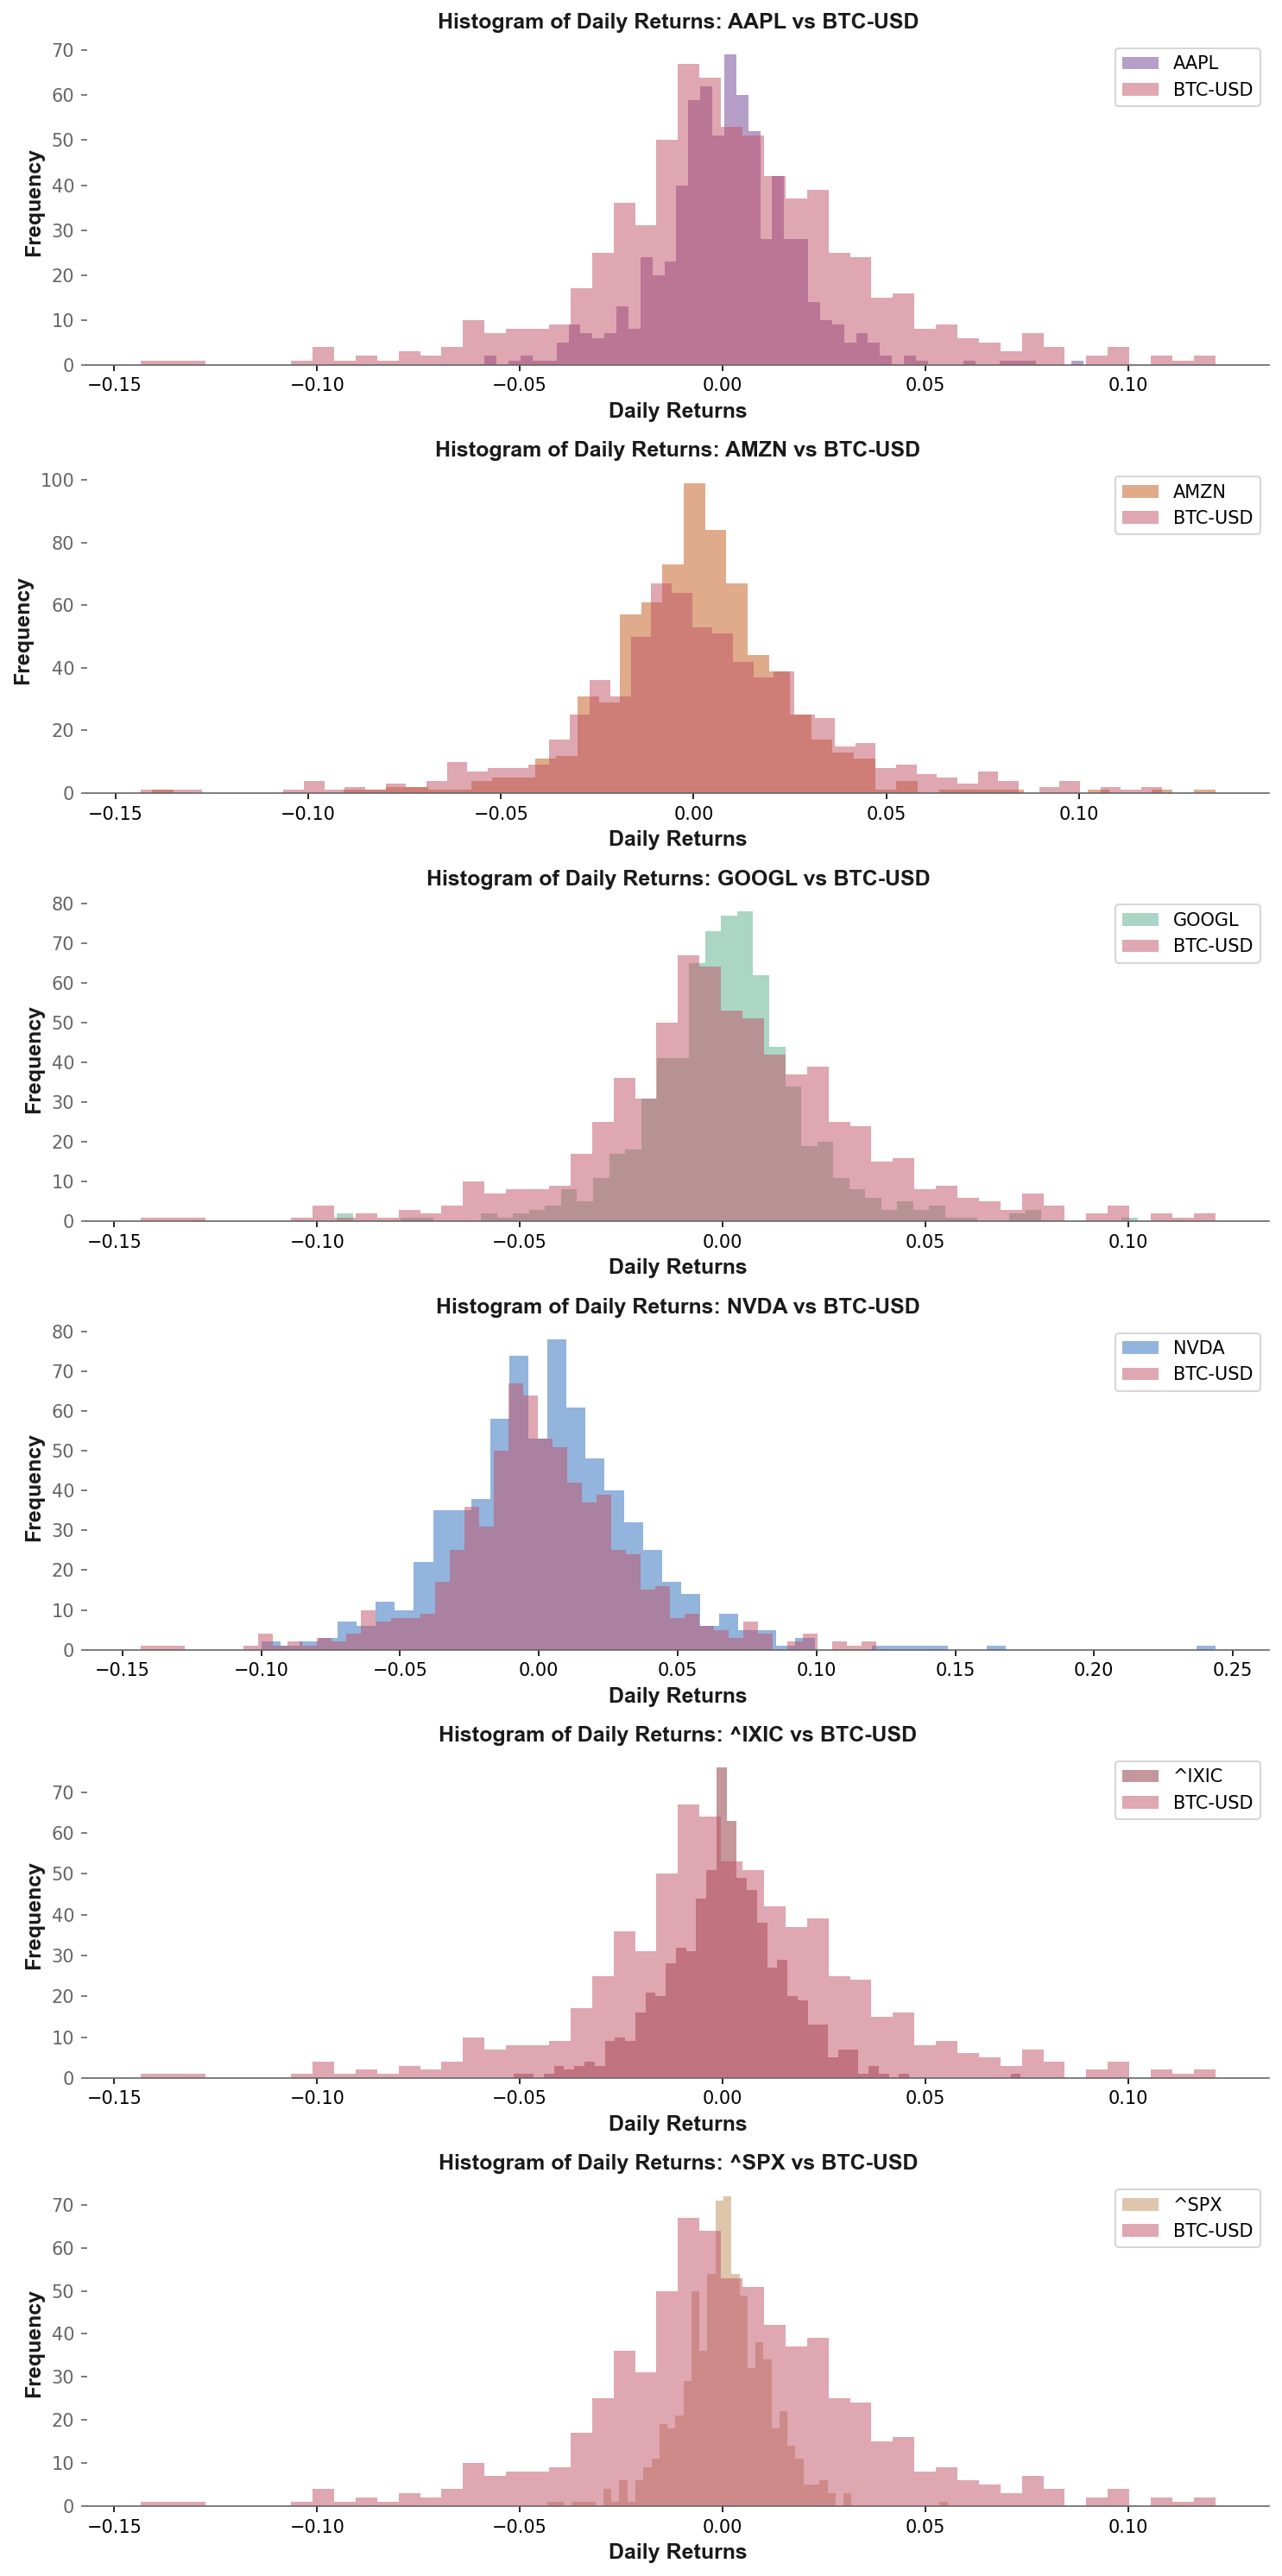

In [111]:
# Select the daily returns of US stocks and Bitcoin
us_stocks = ["AAPL", "AMZN", "GOOGL", "NVDA", "^IXIC", "^SPX"]
btc_returns = returns["Daily"]["BTC-USD"]

# Plot histograms
fig, axes = plt.subplots(
    len(us_stocks), 1, figsize=(10, 20), dpi=150, facecolor="white"
)

for i, stock in enumerate(us_stocks):
    ax = axes[i]
    hist_config_ax(ax, "Daily Returns", "Frequency")
    stock_returns = returns["Daily"][stock]

    ax.hist(stock_returns, bins=50, alpha=0.5, label=stock, color=COLOR_SCALE[i])
    ax.hist(btc_returns, bins=50, alpha=0.5, label="BTC-USD", color=COLOR_SCALE[-1])

    ax.set_title(
        f"Histogram of Daily Returns: {stock} vs BTC-USD",
        fontsize=12,
        fontweight="bold",
        fontname="Arial",
        color=GREY10,
    )
    ax.legend()

plt.tight_layout()
plt.show()

#### Expected Returns And Risks

In [112]:
returns_stats["Daily"].loc[["Mean", "STD"], ["AAPL", "AMZN", "GOOGL", "NVDA", "BTC-USD"]] * 100

Ticker,AAPL,AMZN,GOOGL,NVDA,BTC-USD
Statistics,,,,,
Mean,0.075851,0.048034,0.095006,0.301419,0.142478
STD,1.702902,2.355752,1.992829,3.450906,3.418050


Bitcoin has a higher risk and higher expected return compared to most of the US stocks.

#### What does it show us and what is the trade-off between them?

As it can be seen in the table above, the expected returns (sample mean) and the risks (standard deviation) of the stocks are positively correlated with each other. This means that stocks with more risk have higher expected returns.  

Especially the stocks of AAPL, AMZN, and GOOGL seem to have similar patterns as their expected returns and the standart deviations are close to each other, while NVDA has fatter tails and a higher standart devation with a higher return. 

#### Comparison with Turkish stocks

In [141]:
returns_stats["Daily"].loc[
    ["Mean", "STD"], ["AKBNK.IS", "TUPRS.IS", "XU100.IS"]
] * 100

Ticker,AKBNK.IS,TUPRS.IS,XU100.IS
Statistics,,,
Mean,0.090233,0.181534,0.126400
STD,2.920501,2.549194,1.746828


Turkish stocks may seem to have higher expected returns than US stocks, but commenting solely on expected returns is dangerous as Turkey passes through an inflationary period. Also, it is helpful to comment on the standard deviations (risks) of the Turkish stocks, as they have relatively higher values than the others.

### Other (Comparison, Correlation & Covariance Matrices, Portfolios & Their Statistics)

In [114]:
comparison_monthly = pd.DataFrame(
    {
        "BTC-USD Monthly Returns Mean": returns_stats["Monthly"].loc["Mean", "BTC-USD"],
        "AAPL Monthly Returns Mean": returns_stats["Monthly"].loc["Mean", "AAPL"],
        "BTC-USD Monthly Returns STD": returns_stats["Monthly"].loc["STD", "BTC-USD"],
        "AAPL Monthly Returns STD": returns_stats["Monthly"].loc["STD", "AAPL"],
    },
    index=[0],
)
comparison_monthly

,BTC-USD Monthly Returns Mean,AAPL Monthly Returns Mean,BTC-USD Monthly Returns STD,AAPL Monthly Returns STD
0,0.032647,0.015174,0.185959,0.074793


In [115]:
comparison_daily = pd.DataFrame(
    {
        "BTC-USD Daily Returns Mean": returns_stats["Daily"].loc["Mean", "BTC-USD"],
        "AAPL Daily Returns Mean": returns_stats["Daily"].loc["Mean", "AAPL"],
        "BTC-USD Daily Returns STD": returns_stats["Daily"].loc["STD", "BTC-USD"],
        "AAPL Daily Returns STD": returns_stats["Daily"].loc["STD", "AAPL"],
    },
    index=[0],
)
comparison_daily

,BTC-USD Daily Returns Mean,AAPL Daily Returns Mean,BTC-USD Daily Returns STD,AAPL Daily Returns STD
0,0.001425,0.000759,0.034181,0.017029


---
We calculate the correlation matrix of the stock returns for all periods.

In [116]:
correlation = {period: returns_df.corr() for period, returns_df in returns.items()}
correlation["Monthly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Ticker,,,,,,,,,,
AAPL,1.000000,0.049859,0.659667,0.297924,0.508216,0.583790,-0.132364,0.029092,0.796738,0.740891
AKBNK.IS,0.049859,1.000000,-0.206378,-0.267406,-0.041346,-0.061317,0.599575,0.803187,-0.003780,0.052226
AMZN,0.659667,-0.206378,1.000000,0.518779,0.658584,0.712560,-0.127107,-0.149206,0.828349,0.664197
BTC-USD,0.297924,-0.267406,0.518779,1.000000,0.370615,0.400572,-0.187411,-0.233822,0.513058,0.506584
GOOGL,0.508216,-0.041346,0.658584,0.370615,1.000000,0.629543,-0.020793,-0.073420,0.743363,0.667297
NVDA,0.583790,-0.061317,0.712560,0.400572,0.629543,1.000000,0.041836,0.106098,0.831535,0.697654
TUPRS.IS,-0.132364,0.599575,-0.127107,-0.187411,-0.020793,0.041836,1.000000,0.715341,-0.023157,0.052109
XU100.IS,0.029092,0.803187,-0.149206,-0.233822,-0.073420,0.106098,0.715341,1.000000,0.020348,0.096704
^IXIC,0.796738,-0.003780,0.828349,0.513058,0.743363,0.831535,-0.023157,0.020348,1.000000,0.931698


---
We calculate the covariance matrix of the stock returns for all periods.

In [117]:
covariances = {period: returns_df.cov() for period, returns_df in returns.items()}
covariances["Monthly"]

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Ticker,,,,,,,,,,
AAPL,0.005594,0.000507,0.004643,0.004144,0.002923,0.006913,-0.001280,0.000207,0.003451,0.002594
AKBNK.IS,0.000507,0.018494,-0.002641,-0.006762,-0.000432,-0.001320,0.010543,0.010396,-0.000030,0.000332
AMZN,0.004643,-0.002641,0.008855,0.009078,0.004765,0.010617,-0.001547,-0.001336,0.004515,0.002926
BTC-USD,0.004144,-0.006762,0.009078,0.034581,0.005300,0.011794,-0.004506,-0.004138,0.005526,0.004410
GOOGL,0.002923,-0.000432,0.004765,0.005300,0.005913,0.007665,-0.000207,-0.000537,0.003311,0.002402
NVDA,0.006913,-0.001320,0.010617,0.011794,0.007665,0.025070,0.000856,0.001599,0.007625,0.005171
TUPRS.IS,-0.001280,0.010543,-0.001547,-0.004506,-0.000207,0.000856,0.016719,0.008803,-0.000173,0.000315
XU100.IS,0.000207,0.010396,-0.001336,-0.004138,-0.000537,0.001599,0.008803,0.009059,0.000112,0.000431
^IXIC,0.003451,-0.000030,0.004515,0.005526,0.003311,0.007625,-0.000173,0.000112,0.003354,0.002526


---
We calculate the sharpe ratios of the stock returns for all periods.

In [118]:
sharpe_ratios: Dict[str, Dict[str, pd.Series]] = {
    period: pd.DataFrame(
        {"Sharpe Ratio": returns_stats_df.loc["Mean"] / returns_stats_df.loc["STD"]},
        columns=pd.Index(["Sharpe Ratio"], name="Statistics"),
    ).T
    for period, returns_stats_df in returns_stats.items()
}
sharpe_ratios["Daily"]*np.sqrt(252)

Ticker,AAPL,AKBNK.IS,AMZN,BTC-USD,GOOGL,NVDA,TUPRS.IS,XU100.IS,^IXIC,^SPX
Statistics,,,,,,,,,,
Sharpe Ratio,0.707087,0.490467,0.323683,0.661713,0.756801,1.386558,1.130462,1.148673,0.516613,0.821414


---
Here, we create diversified portfolios with different weights, and calculate their expected returns and standart deviations for all periods.

In [119]:
portfolio_weights = {
    "Portfolio 1": {"BTC-USD": 1.0},
    "Portfolio 2": {"BTC-USD": 1 / 2, "AAPL": 1 / 2},
    "Portfolio 3": {"BTC-USD": 1 / 3, "AAPL": 1 / 3, "GOOGL": 1 / 3},
    "Portfolio 4": {"BTC-USD": 1 / 4, "AAPL": 1 / 4, "GOOGL": 1 / 4, "AMZN": 1 / 4},
}

In [120]:
portfolios_returns_stats = pd.DataFrame(
    {
        portfolio: [
            sum(
                [
                    weight * returns_stats["Monthly"].loc["Mean", ticker]
                    for ticker, weight in weights.items()
                ]
            ),
            np.sqrt(
                weighted_variance(
                    [returns["Monthly"].loc[:, ticker] for ticker in weights.keys()],
                    np.array(list(weights.values())),
                )
            ),
        ]
        for portfolio, weights in portfolio_weights.items()
    },
    index=pd.Index(["Expected Return", "STD"], name="Statistics"),
)

portfolios_returns_stats = pd.concat(
    [
        portfolios_returns_stats,
        returns_stats["Monthly"]
        .loc[["Mean", "STD"], ["BTC-USD", "AAPL", "GOOGL", "AMZN"]]
        .set_index(pd.Index(["Expected Return", "STD"], name="Statistics")),
    ],
    axis=1,
)

portfolios_returns_stats * 100

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4,BTC-USD,AAPL,GOOGL,AMZN
Statistics,,,,,,,,
Expected Return,3.264729,2.391066,2.120992,1.781410,3.264729,1.517404,1.580845,0.762663
STD,18.595868,11.007038,8.870645,8.538407,18.595868,7.479314,7.689479,9.410084


## Part B: Correlation and Regression in Python

#### **1.** Calculate the mean and the st. Deviation of BTC and Apple stocks for monthly returns. How do you comment on them? What is the correlation between these two stocks?

In [121]:
comparison_monthly.T

,0
BTC-USD Monthly Returns Mean,0.032647
AAPL Monthly Returns Mean,0.015174
BTC-USD Monthly Returns STD,0.185959
AAPL Monthly Returns STD,0.074793


The statistical features of particular US tech stock and cryptocurrency,
Apple and BTC, are analyzed in this example using data collected from Yahoo Finance. Apple and BTC were found to have a monthly return risk measured by a standard deviation of approximately 7.5% and 18.6% respectively. Moreover, Apple and BTC were found to have a monthly return of approximately 1.5% and 3.2% respectively. Even though on average, the monthly returns of BTC are higher than those of Apple, it must be noted that the average monthly return risk measured by a standard deviation of BTC is significantly higher than those of Apple.

In [122]:
correlation["Monthly"].loc["AAPL", "BTC-USD"]

np.float64(0.2979238927743349)

Apple and BTC were found to have a monthly correlation coefficient of 0.3 ,which indicates a positive but small relationship between monthly returns of Apple and BTC.

#### **2.** Find the correlation between BTC returns and other US stock return series. Comment on your findings on looking at my other notes (Risk Return Calculations).

In [123]:
correlation["Monthly"]["BTC-USD"].drop(
    ["AKBNK.IS", "TUPRS.IS", "XU100.IS", "BTC-USD", "AAPL"], axis=0
)

Ticker
AMZN     0.518779
GOOGL    0.370615
NVDA     0.400572
^IXIC    0.513058
^SPX     0.506584
Name: BTC-USD, dtype: float64

Other US stock return series and BTC were found to have a positive monthly correlation coefficient ranging from 0.37 to 0.52 . Even though they have positive relationship, they do not have significant relationship. A correlation coefficient 1 indicates a perfect positive relationship and as correlation coefficient, approaches to 0, it indicates that these two variables move independently. This means that changes in
the return of one asset have little or no effect on the return of the other
and vice versa. In our data we may conclude changes in return of one variable could cause small changes in return of other variable and vice versa.

#### **3.** Sharpe Ratio is a very popular performance ratio indicating how much return is expected for a given risk. The higher the Sharpe ratio the better the risk adjusted expected return. Calculate the daily, weekly, monthly sharpe ratio for US stocks. What do we find? How would you manage your portfolio after your findings. What is the Sharpe ratio of Bitcoin? (Note that we simplified Sharpe Ratio by assuming interest rates are zero, where r is the interest rates.)

In [124]:
sharpe_ratios["Daily"].drop(["AKBNK.IS", "TUPRS.IS", "XU100.IS"], axis=1)

Ticker,AAPL,AMZN,BTC-USD,GOOGL,NVDA,^IXIC,^SPX
Statistics,,,,,,,
Sharpe Ratio,0.044542,0.02039,0.041684,0.047674,0.087345,0.032544,0.051744


In [125]:
sharpe_ratios["Weekly"].drop(["AKBNK.IS", "TUPRS.IS", "XU100.IS"], axis=1)

Ticker,AAPL,AMZN,BTC-USD,GOOGL,NVDA,^IXIC,^SPX
Statistics,,,,,,,
Sharpe Ratio,0.096035,0.040285,0.076331,0.090778,0.207264,0.072299,0.105968


In [126]:
sharpe_ratios["Monthly"].drop(["AKBNK.IS", "TUPRS.IS", "XU100.IS"], axis=1)

Ticker,AAPL,AMZN,BTC-USD,GOOGL,NVDA,^IXIC,^SPX
Statistics,,,,,,,
Sharpe Ratio,0.20288,0.081047,0.175562,0.205585,0.419211,0.160605,0.236461


We can see in our results as time frames get bigger Sharpe Ratio is also bigger. Hence for a given risk expected return is higher in longer time frames. We may conclude day trading is more risky compared to holding the stocks in longer time frames. While NVDIA has the highest daily, weekly and monthly sharpe ratio, Amazon has the lowest in the same time frames. In the same time frames BTC has daily, weekly and monthly Sharpe Ratio of 0.041 , 0.075 , 0.174 respectively. Even though NVDIA has the best sharpe ratio, best expexted return for given risk, it may be wise to diversify our portfolio and include other stocks to reduce risk further. For example we may form a portfolio excluding Amazon and NASDAQ with equal weights to reduce risk.

#### **4.** Markowitz Frontier: Please first read the risk-return calculations before attempting to solve this question. Suppose your wealth is 100 $. First you invest all your wealth in BTC i.e w1=100%. Then you do divide your portfolio 50% BTC, 50% Apple. Then 1/3 BTC, 1/3 Google, 1/3 Apple. Finally you divide your wealth equally for all the stocks you have i.e w1=w2=w3=w4 25% for each four stocks including Amazon.

**a.** Calculate your expected return and st. Deviation of your portfolio for each of
these 4 cases.

In [127]:
portfolios_returns_stats.drop(["BTC-USD", "AAPL", "GOOGL", "AMZN"], axis=1) * 100

,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4
Statistics,,,,
Expected Return,3.264729,2.391066,2.120992,1.781410
STD,18.595868,11.007038,8.870645,8.538407


In [128]:
portfolios_returns_stats.loc["Expected Return", :]

Portfolio 1    0.032647
Portfolio 2    0.023911
Portfolio 3    0.021210
Portfolio 4    0.017814
BTC-USD        0.032647
AAPL           0.015174
GOOGL          0.015808
AMZN           0.007627
Name: Expected Return, dtype: float64

**b.** Plot the expected return of portfolio 1,2,3,4 against number of stocks. Plot the
standard deviation of each portfolio against the number of stocks in your
portfolio

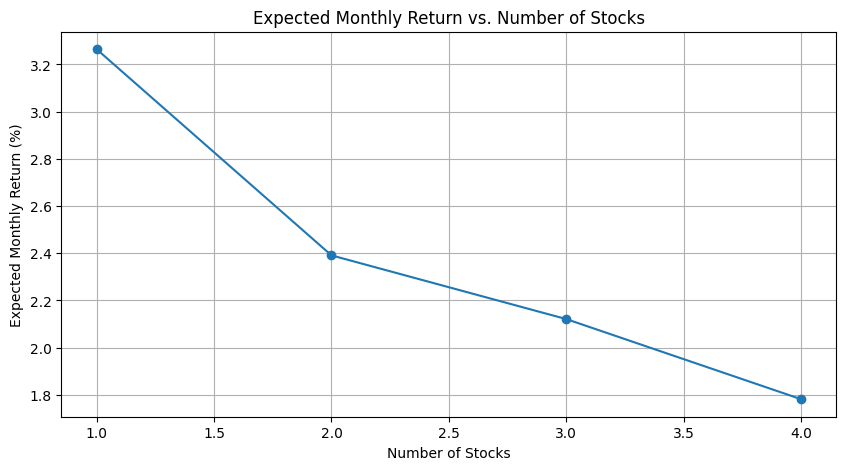

In [129]:
# Expected Return'ün varlık sayısı değiştikçe nasıl değiştiğini plot eden bir grafik yapıyoruz.
num_stocks = [1, 2, 3, 4]
plt.figure(figsize=(10, 5))
plt.plot(
    num_stocks,
    portfolios_returns_stats.drop(["BTC-USD", "AAPL", "GOOGL", "AMZN"], axis=1).loc[
        "Expected Return"
    ]
    * 100,
    marker="o",
)
plt.title("Expected Monthly Return vs. Number of Stocks")
plt.xlabel("Number of Stocks")
plt.ylabel("Expected Monthly Return (%)")
plt.grid(True)
plt.show()

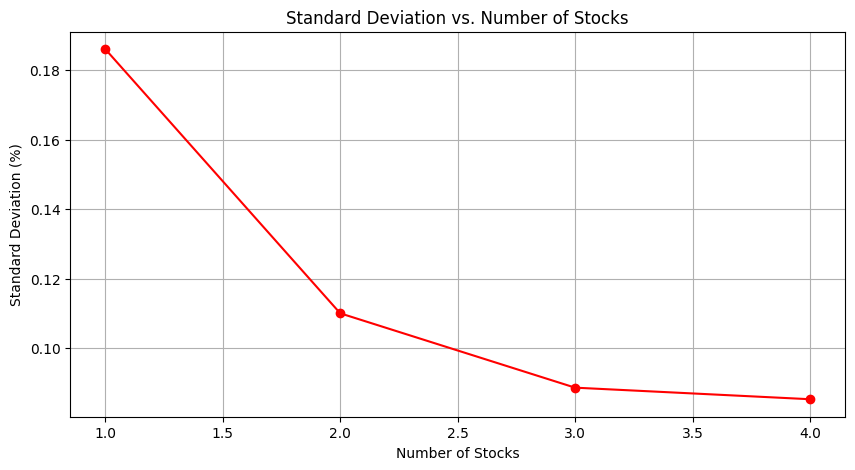

In [130]:
# Std. Dev'in varlık sayısı değiştikçe nasıl değiştini plot eden bir grafik yapıyoruz.
plt.figure(figsize=(10, 5))
plt.plot(
    num_stocks,
    portfolios_returns_stats.drop(["BTC-USD", "AAPL", "GOOGL", "AMZN"], axis=1).loc[
        "STD"
    ],
    marker="o",
    color="red",
)
plt.title("Standard Deviation vs. Number of Stocks")
plt.xlabel("Number of Stocks")
plt.ylabel("Standard Deviation (%)")
plt.grid(True)
plt.show()

**c.**  What do you observe in terms of your standard deviation of your portfolio?

As we increase the number of stocks in our portfolio, standard deviation of our portfolio decreases from 18% to 8%. Hence by holding a variety of
investments, the portfolio becomes less vulnerable to the performance
of any single asset. This is because of the diversification property of portfolio selection. As we added more assets to our portfolio, we reduced the portfolio risk. This effect can get even more significant if the assets have a
negative correlation.

**d.** What do you expect your results if you add more stocks into your portfolio?

As we increase the number of stocks, we will further reduce the portfolio risk. However, this may come at the cost of our expected returns. One can see from above while portfolio risk decreases as we increase the number of stocks, portfolios' expected return also decreases. The risk-return trade-off in finance is the principle that the potential
return on an investment increases with the risk associated with that
investment. In other words, investors must balance the potential for
higher returns with the increased likelihood of losses when making
investment decisions.

**e.** Can you generalize the saying “don’t put all of your eggs into a basket” with this exercise?

Yes, we can generalize the saying because we can clearly see decrease in portfolio risk. However, we should consider risk return trade-off while choosing our portfolio. We may consider Markowitz frontier to find optimal portfolio.

### Stock Beta

#### **5.** Please focus on your monthly Turkish and US stocks and their stock indices XU100 and NASDAQ.
Choose one stock say Apple. Estimate the regression equation below.


$$
\begin{align}
R_{i,t} = \alpha + \beta R_{m,t}
\end{align}
$$


> $R_{i,t}$: i th stock arithmetic return for stock i say: APPLE for month t.  
$R_{m,t}$: is the return of a stock index (i.e NASDAQ’s monthly stock returns), m is the
market index

In [131]:
regression_model = smf.ols("AAPL ~ IXIC", data={
    "IXIC": returns["Monthly"]["^IXIC"],
    "AAPL": returns["Monthly"]["AAPL"],
})
regression_results = regression_model.fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     74.74
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           5.90e-11
Time:                        14:39:18   Log-Likelihood:                 76.004
No. Observations:                  45   AIC:                            -148.0
Df Residuals:                      43   BIC:                            -144.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0056      0.007      0.811      0.4

#### **6.** Estimate the beta’s for each stocks. (Turkish and US stocks separately use BIST100 $R_{m,t}$ for the for Turkish Stocks. 2 betas for Turkey (AKB, Tupras) and 4 for US (APPLE, GOOGLE, NVDIA, AMAZON.)

In [132]:
turkey_monthly_returns = {
    "XU100": returns["Monthly"]["XU100.IS"],
    "AKBNK": returns["Monthly"]["AKBNK.IS"],
    "TUPRS": returns["Monthly"]["TUPRS.IS"],
}

usa_monthly_returns = {
    "IXIC": returns["Monthly"]["^IXIC"],
    "GOOGL": returns["Monthly"]["GOOGL"],
    "AAPL": returns["Monthly"]["AAPL"],
    "AMZN": returns["Monthly"]["AMZN"],
    "NVDA": returns["Monthly"]["NVDA"],
}

In [133]:
turkey_regression_results = {
    k: smf.ols(f"{k} ~ XU100", data=turkey_monthly_returns).fit()
    for k in list(turkey_monthly_returns.keys())[1:]
}

usa_regression_results = {
    k: smf.ols(f"{k} ~ IXIC", data=usa_monthly_returns).fit()
    for k in list(usa_monthly_returns.keys())[1:]
}

In [134]:
regression_stats = pd.DataFrame(
    {
        **{
            k: {
                "Beta": v.params["XU100"],
                "t-value": v.tvalues["XU100"],
                "p-value": v.pvalues["XU100"],
                "R-squared": v.rsquared,
            }
            for k, v in turkey_regression_results.items()
        },
        **{
            k: {
                "Beta": v.params["IXIC"],
                "t-value": v.tvalues["IXIC"],
                "p-value": v.pvalues["IXIC"],
                "R-squared": v.rsquared,
            }
            for k, v in usa_regression_results.items()
        }
    },
    index=pd.Index(["Beta", "t-value", "p-value", "R-squared"], name="Statistics"),
)
regression_stats.columns.name = "Ticker"
regression_stats = regression_stats.round(decimals=4)

In [135]:
for k, v in turkey_regression_results.items():
    print(f"{k}\n{v.summary()}\n\n")

AKBNK
                            OLS Regression Results                            
Dep. Variable:                  AKBNK   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     78.16
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           3.16e-11
Time:                        14:39:18   Log-Likelihood:                 49.744
No. Observations:                  45   AIC:                            -95.49
Df Residuals:                      43   BIC:                            -91.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.014      0.286   

In [136]:
for k, v in usa_regression_results.items():
    print(f"{k}\n{v.summary()}\n\n")

GOOGL
                            OLS Regression Results                            
Dep. Variable:                  GOOGL   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     53.11
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           4.94e-09
Time:                        14:39:18   Log-Likelihood:                 70.189
No. Observations:                  45   AIC:                            -136.4
Df Residuals:                      43   BIC:                            -132.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.008      0.844   

#### **7.** How do you compare the beta’s in US and Turkey separately? Which stock seemed to have highest beta? Which stocks would you buy if you expect a sharp drop in growth in US economy.

In [137]:
regression_stats.loc[["Beta"], :].T

Statistics,Beta
Ticker,
AKBNK,1.1476
TUPRS,0.9718
GOOGL,0.9869
AAPL,1.0289
AMZN,1.3459
NVDA,2.2732


##### $\beta$ values
Apparently, the $\beta$'s of the stocks in US and Turkey are as the following:

**Turkey:**
- $\beta_\text{AKBNK} = 1.1474$
- $\beta_\text{TUPRS} = 0.9718$

**USA:**
- $\beta_\text{AAPL} = 1.0293$
- $\beta_\text{AMZN} = 1.3460$
- $\beta_\text{GOOGL} = 0.9875$
- $\beta_\text{NVDA} = 2.2722$

In the Turkish stock market, the stock with the highest beta is AKBNK (Akbank).  
In the US stock market, the stock with the highest beta is NVDA (Nvidia).

Thus, if a sharp drop is expected in the US economy, the stocks with higher beta like NVDA should be avoided as they would be affected more from the drop because of their high beta. Thus, GOOGL is more considerable to buy.

#### **8.** Do a statistical t test whether beta is significant or not? How does the model fit look at their R-square?

In [138]:
regression_stats.loc[["t-value", "p-value", "R-squared"], :].T

Statistics,t-value,p-value,R-squared
Ticker,,,
AKBNK,8.8410,0.0,0.6451
TUPRS,6.7129,0.0,0.5117
GOOGL,7.2876,0.0,0.5526
AAPL,8.6453,0.0,0.6348
AMZN,9.6961,0.0,0.6862
NVDA,9.8164,0.0,0.6915


In [139]:
print("Number of observations: ", regression_results.nobs)
print("Degrees of freedom: ", regression_results.df_resid)

Number of observations:  45.0
Degrees of freedom:  43.0


##### $t$-values
The $t$-values are as the following:

**Turkey:**
- $t_\text{AKBNK} = 8.811$
- $t_\text{TUPRS} = 6.700$

**USA:**
- $t_\text{AAPL} = 8.656$
- $t_\text{AMZN} = 9.692$
- $t_\text{GOOGL} = 7.286$
- $t_\text{NVDA} = 9.794$

All of these $t$-values have 43 degrees of freedom.

When we calculate their $p$-values with 43 degrees of freedom, it is revealed that they are very close to 0 as it is shown in the table.  
This means that the $\beta$ values are statistically significant.

##### $R^2$ values
And the $R^2$ values are as the following:

**Turkey:**
- $R^2_\text{AKBNK} = 0.6435$
- $R^2_\text{TUPRS} = 0.5108$

**USA:**
- $R^2_\text{AAPL} = 0.6354$
- $R^2_\text{AMZN} = 0.6860$
- $R^2_\text{GOOGL} = 0.5532$
- $R^2_\text{NVDA} = 0.6905$

The $R^2$ values tells us about that how much of the variety is explained by the dependent variable, in this case the dependent variable is stock indices.